# Theoretical network.

## Contents.
* [Introduction](#intro)
* [Imports](#imports)
* [Parameters](#parameters)
* [Functions](#fun)
* [Main nodes](#main)
  * [Heatmap](#heatmain)
* [Secondary nodes](#sec)
  * [Heatmap](#heatmapsec)

## Introduction. <a class="anchor" id="intro"></a>

To systematize the study of the topological properties of the network and how they affect the cell-fate commitment process, we perform a simple theoretical study of the toggle switch network's robustness to cell fate commitment under the effect of the addition of dimensions. Initially---image below---, this network is composed of two nodes (main nodes) represented in the network by NANOG and GATA6, for example, including their mutual repression.

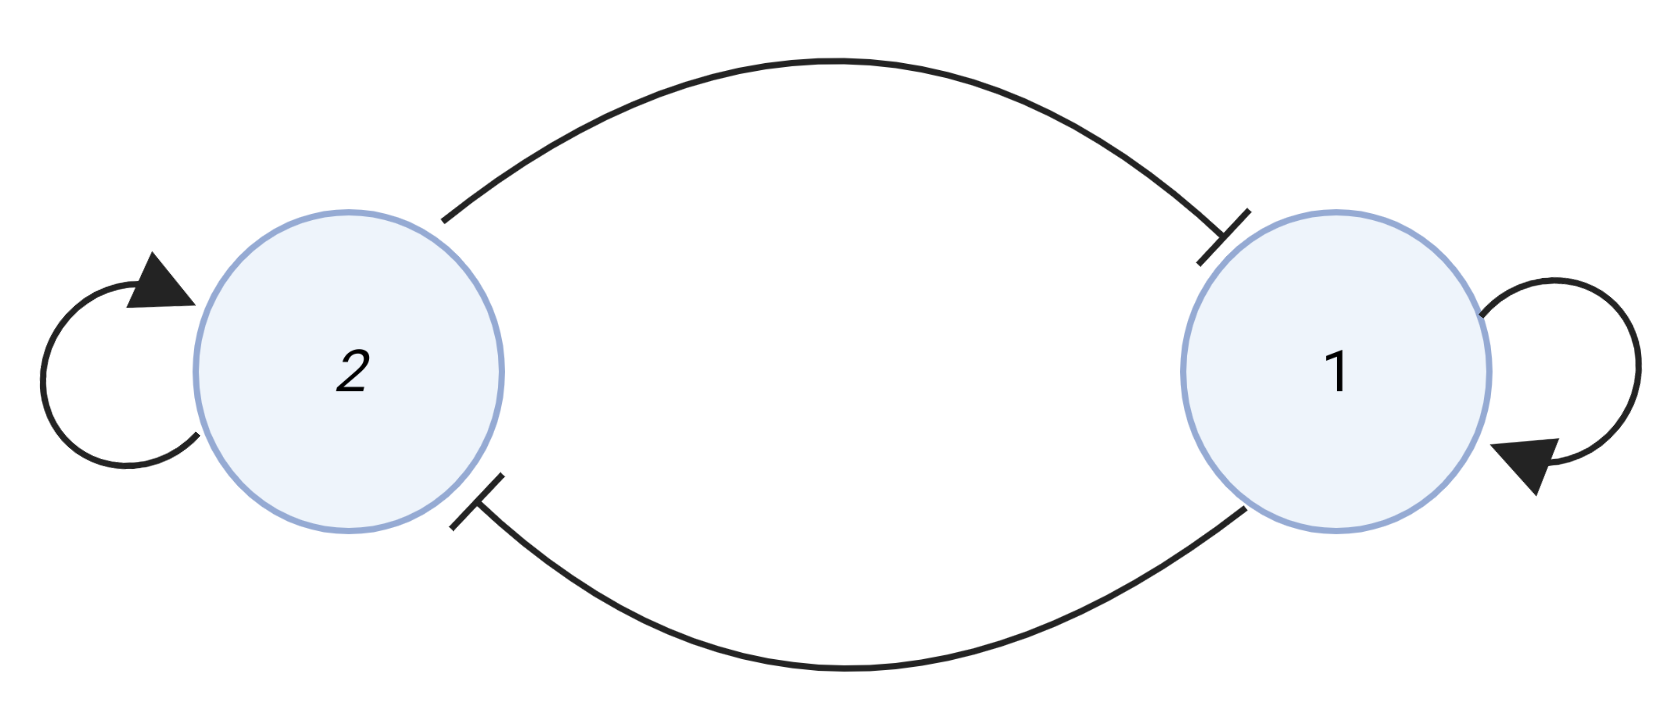

To these, we connected another set of nodes (secondary nodes) that, in turn, do not repress each other, nor do they self-activate. Furthermore, secondary nodes are connected to only one of the main nodes, so we will call each loop that includes a main node and its secondary node a 'branch'. This division into main and secondary nodes is in accordance with the finding that a few, key genes (here, the main nodes) in a GRN may be perturbed in such a way that the cell fate commitment is altered, while perturbations on other genes (here, the secondary nodes) do not alter the cell fate.

We aim to explore the impact of the dimensionality of the system on the robustness under perturbations, and how this is articulated through complex networks of secondary genes. We explored two simple case scenarios. First, adding the secondary nodes in __parallel__ to each other---i.e., each of these is connected to one of the main nodes, but not to each other:

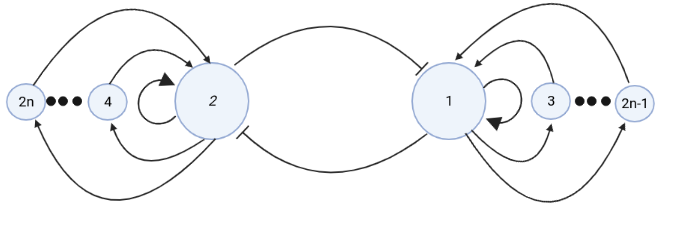

Second, adding the secondary nodes in __series__ to each other---i.e., each node is connected to the next secondary node:



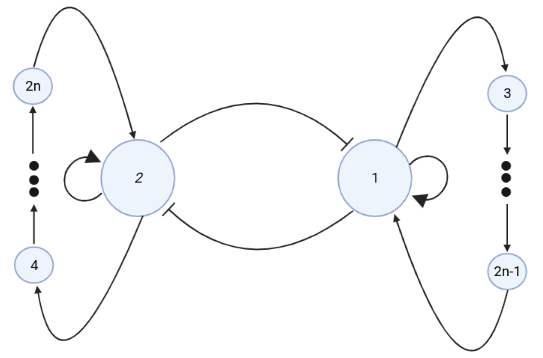

These systems are bistable for a certain range of parameters.

We start with an initial condition for the nodes on one branch higher than the other, to make sure the system commits to one of the two attractors. We let the system evolve to a stationary state. Once this state is reached, one of the nodes expressing high concentration (active)---either a main node or a secondary node---is perturbed by changing its self-degradation constant $k$ to a value defined here as $f_k$, during a time $t_{perturb}$. This would correspond, experimentally, to an increase in degradation through the incorporation of an external agent. This way, we perturb the landscape which potentially may change the attractor stability landscape, so that it could switch to the other possible attractor state. After the time of perturbation $t_{perturb}$, we return $f_k$ to its original value $k$ and let the system evolve again until relaxation.

## Imports. <a class="anchor" id="imports"></a>

In [1]:
# Import necessary packages
# The line above each package contains the instructions needed to install them.

# import Pkg; Pkg.add("DifferentialEquations")
using DifferentialEquations
# import Pkg; Pkg.add("Random")
using Random
# import Pkg; Pkg.add("Plots")
using Plots
# import Pkg; Pkg.add("LaTeXStrings")
using LaTeXStrings
# import Pkg; Pkg.add("PyPlot")
using PyPlot
# import Pkg; Pkg.add("PyCall")
using PyCall
lines = pyimport("matplotlib.lines")
# import Pkg; Pkg.add("Distributions")
using Distributions
# import Pkg; Pkg.add("DataFrames")
using DataFrames

## Parameters. <a class="anchor" id="parameters"></a>

We change here the value of the repression parameter $b$ to guarantee bistability of the toggle switch. All other parameters remain unchanged with respect to all previous notebooks.

In [2]:
# Parameters:
S = 0.5   # strength of regulatory interaction
n = 3     # Hill coefficient
a = 0.38  # Activation constant
b = 1.0    # Repression constant
k = 1.0;  # Self-degradation constant

In [3]:
k_vec = 1.:0.1:5.
N_vec = 0:2:8
t_perturb_vec = 0:1:50;

In [4]:
tspan = (0.,50.)
t_extra = 100.;

## Functions. <a class="anchor" id="fun"></a>

### Sparse matrices.

We need two different sparse matrices for an arbitrary number of total nodes: one for the parallel network, and another one for the series network. Besides, each of these may include a self-loop on the main nodes, or not.

We always have at least two nodes: the main ones, `1` and `2`. When adding secondary nodes, those connected to `1` will be odd-numbered (i.e., `3,5,7,...`), while those connected to `2` will be even-numbered (i.e., `2,4,6,...`). 

If the total number of nodes is odd, one branch will have one more secondary node than the other. E.g., if `num_nod=5`, nodes `1,3`, and `5` will form a branch, while nodes `2` and `4` will form the other branch.

In [5]:
function get_mswitch_parallel(num_nod,w_or_wo)
    # num_nod: number of total nodes (i.e., secondary + main nodes)
    # str_w_or_wo_self: "w" includes self-loop on main nodes,
    # "wo" no self-loop on main nodes
    if w_or_wo == "w"
        mswitch_equiv = [
            [1,2,-1],[1,1,1],[2,1,-1],[2,2,1]
        ]
    else
        mswitch_equiv = [
            [1,2,-1],[2,1,-1]
        ]
    end
   
    if num_nod == 0
        return mswitch_equiv
    elseif num_nod == 1
        return push!(mswitch_equiv,[1,3,1],[3,1,1],[2,4,1],[4,2,1])
    else
        return push!(mswitch_equiv,[1,3,1],[3,1,1],[2,4,1],[4,2,1],[1,5,1],[5,1,1])
    end
    
    
end;

In [6]:
function get_mswitch_series(num_nod,str_w_or_wo_self)
    # num_nod: number of total nodes (i.e., secondary + main nodes)
    # str_w_or_wo_self: "w" includes self-loop on main nodes,
    # "wo" no self-loop on main nodes
    
    if str_w_or_wo_self == "w"
        mswitch_series = [[1,2,-1],[1,1,1],[2,1,-1],[2,2,1]]
    elseif str_w_or_wo_self == "wo"
        mswitch_series = [[1,2,-1],[2,1,-1]]
    end
    
    if num_nod == 0
        return mswitch_series
    elseif num_nod == 1
        return push!(mswitch_series,
            [Int(1),Int(3),1],[Int(3),Int(1),1],
            [Int(2),Int(4),1],[Int(4),Int(2),1])
    elseif num_nod == 2
        return push!(mswitch_series,
            [Int(1),Int(3),1],[Int(3),Int(5),1],[Int(5),Int(1),1],
            [Int(2),Int(4),1],[Int(4),Int(6),1],[Int(6),Int(2),1])
    end  # ends if num_nod == 0
    
    total_nodes = 2*num_nod+2

    push!(mswitch_series,
           [Int(1),Int(3),1],
           [Int(2),Int(4),1])
        
    for i in 5:total_nodes
        
        if isodd(Int(i))
            if Int(i+1) != Int(total_nodes)
                push!(mswitch_series,
                    [Int(i-2),Int(i),1])
            else
                push!(mswitch_series,
                    [Int(i-2),Int(i),1],[Int(i),1,1])
                
            end  #ends if i+1 != final_N
    
        else
            if Int(i)!=Int(total_nodes)
                push!(mswitch_series,
                    [Int(i-2),Int(i),1])
            else
                push!(mswitch_series,
                    [Int(i-2),Int(i),1],[Int(i),2,1])
                
            end  #ends if i != final_N
        end  # ends if isodd(i)
        
    end  # ends for i in 3:final_N
    
    return mswitch_series
    
end;  # ends function

### Systems of ODEs.

The systems of ODEs that describe each of the 4 scenarios are given here: parallel or series network, each for the case of no pertrubation on $k$, and of perturbation of $k$ to a value $f_k$. 

As input paramters `p`, these functions need a sparse matrix (one from subsection above), the number of secondary nodes on a single branch `nnodes`, the parameters of the ODEs (`a,b,n,S,k`), and the parameters for perturbation `f_k` and `node_perturb` (e.g., `1` or `2` to perturb a main node, or larger numbers for perturbing a secondary node). More than one node may be perturbed.

In [7]:
function ode_toggle_series(x,p,t)
    # Parameters p:
    mswitch_here, nnodes, a, b, n, S, k = p
    
    nnodes = 2*nnodes +2
    
    xi = zeros(Int(nnodes)) # nnodes factors
    
    for i in 1:Int(nnodes)
        xi[i] -= k*x[i]
    end

    #Sum over the different connections in the sparse matrix
    for i in mswitch_here

        # If i[3]==1, we have an activator:
        if i[3] == 1
            xi[i[2]] += a*x[i[1]]^n/(S^n + x[i[1]]^n)
        # If i[3]==-1, we have a repressor:
        else
            xi[i[2]] += b*S^n/(S^n + x[i[1]]^n)
        end
    end

    return xi
end;

In [8]:
function ode_toggle_series_perturb(x,p,t)
    # Parameters p:
    # node_perturb may be a number or a vector.
    mswitch_here, nnodes, a, b, n, S, k, f_k, node_perturb = p
    
    nnodes = 2*nnodes +2
    
    xi = zeros(Int(nnodes)) # nnodes factors
    
    for i in 1:Int(nnodes)
        # Set the nodes we perturb with a different k:
        if any(i .== Int.(node_perturb))
            xi[i] -= f_k*x[i]
        else
            xi[i] -= k*x[i]
        end
    end

    #Sum over the different connections in the sparse matrix
    for i in mswitch_here

        # If i[3]==1, we have an activator:
        if i[3] == 1
            xi[i[2]] += a*x[i[1]]^n/(S^n + x[i[1]]^n)
        # If i[3]==-1, we have a repressor:
        else
            xi[i[2]] += b*S^n/(S^n + x[i[1]]^n)
        end  # ends if on i[3]
        
    end # ends for on mswitch

    return xi
end;

In [9]:
function ode_toggle_parallel(x,p,t)
    # Parameters p:
    mswitch_here, nnodes, a, b, n, S, k = p
    
    n_here = nnodes*2
    
    if nnodes == 0
        n_tot = 2
    elseif nnodes == 1
        n_tot = 4
    else
        n_tot = 5
    end
    
    xi = zeros(Int(n_tot)) # nnodes factors
    
    for i in 1:Int(n_tot)
        xi[i] -= k*x[i]
    end

    #Sum over the different connections in the sparse matrix
    for i in mswitch_here
        if i[1] == 5 && i[2] == 1
            a_here = a*(n_here-1)
        elseif i[1] == 4 && i[2] == 2
            a_here = a*n_here
        else
            a_here = a
        end
        
        # If i[3]==1, we have an activator:
        if i[3] == 1
            xi[i[2]] += a_here*x[i[1]]^n/(S^n + x[i[1]]^n)
        # If i[3]==-1, we have a repressor:
        else
            xi[i[2]] += b*S^n/(S^n + x[i[1]]^n)
        end
    end

    return xi
end;

In [10]:
function ode_toggle_parallel_perturb(x,p,t)
    # Parameters p:
    # node_perturb may be a number or a vector.
    mswitch_here, nnodes, a, b, n, S, k, f_k, node_perturb = p
    
    if nnodes == 0
        n_tot = 2
    elseif nnodes == 1
        n_tot = 4
    else
        n_tot = 5
    end
    
    xi = zeros(Int(n_tot)) # nnodes factors
    
    for i in 1:Int(n_tot)
        # Set the nodes we perturb with a different k:
        if any(i .== Int(node_perturb))
            xi[i] -= f_k*x[i]
        else
            xi[i] -= k*x[i]
        end
    end
    
    if any(nnodes .== [0,1])
#         println(mswitch_here)
        for i in mswitch_here
            
            a_here = a
            
            # If i[3]==1, we have an activator:
            if i[3] == 1
                xi[i[2]] += a_here*x[i[1]]^n/(S^n + x[i[1]]^n)
            # If i[3]==-1, we have a repressor:
            else
                xi[i[2]] += b*S^n/(S^n + x[i[1]]^n)
            end  # ends if on i[3]
        
        end # ends for on mswitch
        
    else
        n_here = nnodes*2
        #Sum over the different connections in the sparse matrix
        for i in mswitch_here
            
            if i[1] == 5 && i[2] == 1
                a_here = a*(n_here-1)
            elseif i[1] == 4 && i[2] == 2
                a_here = a*n_here
            else
                a_here = a
            end  # ends if on i[3]
            
            # If i[3]==1, we have an activator:
            if i[3] == 1
                xi[i[2]] += a_here*x[i[1]]^n/(S^n + x[i[1]]^n)
            # If i[3]==-1, we have a repressor:
            else
                xi[i[2]] += b*S^n/(S^n + x[i[1]]^n)
            end  # ends if on i[3]
            
        end # ends for on mswitch
    end  # ends if on any(nnodes .== [0,1])

    return xi
end;

### Iteratively change t_perturb, k, and the number of nodes.

`change_t` solves the system of equations given by the sparse matrix `mswitch_t` and changing the time of perturbation: first we solve the unperturbed system, then use the solution as the starting point of a new simulation where we perturb a node, and finally come back to the unperturbed system. Here we repeat this for different t_perturbs, but we could also place this function within a loop of N's and k's to change these as well (in fact, we do this in the `get_sols`function).

In [11]:
function change_t(
        ode_fun,ode_fun_perturb,t_vector,n_perturb,k_fun,ic, N_tot,mswitch_t, equiv_par
    )
    # ode_fun: function we use to solve the original system.
    # ode_fun_perturb:function we use to solve the perturbed system.
    # t_vector: vector of t_perturb's, time of perturbation during which we change k for vector n_remove.
    # n_perturb: nodes to perturb, may be a number or a list.
    # k_fun: k to choose the degradation during a t_perturb.
    # ic: initial condition.
    # N: number of nodes in the network.
    # mswitch_t: matrix of connections.
    # equiv_par: control whether we're simulating the parallel system (true), or the series system (false).
    
    # Output: list of lists.
    # First component: list of lists, first component: t of the three simulations; 
    # Second component: concentration of nodes for the three simulations
    
    sols_k = []
    sols_k_t = []


    for tt in t_vector

        # Solve initial system:

        problem_tog = ODEProblem(ode_fun,ic,tspan,[mswitch_t,N_tot,a,b,n,S,k])
        sol_tog = solve(problem_tog)

        # Solve system removing two nodes (here, symmetric nodes) during t_perturb
        # and with a degradation constant kk for the nodes we remove:

        problem_tog_2 = ODEProblem(
            ode_fun_perturb,sol_tog[end],(tspan[2],tspan[2]+Float64(tt)), 
            [
                mswitch_t,N_tot,a,b,n,S,k,Float64(k_fun),n_perturb
            ]
        )
        sol_tog_2 = solve(problem_tog_2)
        
        # Solve initial system, but with initial condition the final point
        # of the perturbed system.
        
        problem_tog_3 = ODEProblem(ode_fun,sol_tog_2[end],
            (tspan[2]+Float64(tt),tspan[2]+Float64(tt)+Float64(t_extra)), 
            [mswitch_t,N_tot,a,b,n,S,k]
        )
        sol_tog_3 = solve(problem_tog_3)
        
        # Save solutions for the current tt:
        all_sol = []
        append!(all_sol,sol_tog.u)
        append!(all_sol,sol_tog_2.u)
        append!(all_sol,sol_tog_3.u)
        
        # Save t:
        all_t = []
        append!(all_t,sol_tog.t)
        append!(all_t,sol_tog_2.t)
        append!(all_t,sol_tog_3.t)
        
        # Save solutions and t for all k:
        push!(sols_k,all_sol)
        push!(sols_k_t,all_t)
        
        
        # Check progress:
        #print(tt,"/",t_vector[end],"\t")
        
        end  # ends for kk in k_vector
    
    return [sols_k_t,sols_k]
    
end;  # ends function

Solve the system of equations of `change_t` where we change the time of perturbation, but also changing $k$ and the number of nodes. 

Arguments:
* The first argument, `fun_here` is the function to build the sparse matrix: `get_mswitch_parallel` or `get_mswitch_series`. 
* `ode_fun` is the unperturbed system of ODEs: `ode_toggle_series` or `ode_toggle_parallel`.
* `ode_fun_perturb` is the perturbed system of ODEs: `ode_toggle_series_perturb` or `ode_toggle_parallel_perturb`.
* `w_or_wo` may be "w" for including the self-loop on main nodes. or "wo" if we do not want to include it.
* `N_vec_here`: list of number of secondary nodes to add to the network.
* `k_vec_here`: list of perturbation on $k$, i.e. `f_k`.
* `t_perturb_vec_here`: list of time perturbations. 
* `n_perturb_here`: node or lists of nodes to be perturbed.
* `equiv_parallel`: `true` if we simulate the parallel system, `false` for the series system.

In [12]:
function get_sols(
        fun_here, ode_fun, ode_fun_perturb, w_or_wo,
        N_vec_here, k_vec_here, t_perturb_vec_here, n_perturb_here, equiv_parallel = false)
    # fun_here: function to create mswitch
    # ode_fun: function we use to solve the original system
    # ode_fun_perturb: function we use to solve the perturbed system
    # equiv_parallel: control whether we're simulating the equivalent parallel system
final_sol_t = []
final_sol = []

# initialize empty xj and mswitch because sometimes julia
# gives an error where it cannot find these when defined 
# within the loop
xj_here = []
mswitch_get_sol = []

# Change N:
for nn in N_vec_here
    
    # matrix of connections:
    mswitch_get_sol = fun_here(Int(nn),w_or_wo)

    if !equiv_parallel
        mswitch_equiv = copy(mswitch_get_sol)
        # i.c.
        xj_here = zeros(Int(2*nn+2)) .+ 1e-3; xj_here[1:2:Int(2*nn+2)] .= 2.
    else
        # i.c.
        if nn == 0
            xj_here = zeros(Int(2)) .+ 1e-3; xj_here[[1]] .= 2.
        elseif nn == 1
            xj_here = zeros(Int(4)) .+ 1e-3; xj_here[[1,3]] .= 2.
        else
            xj_here = zeros(Int(5)) .+ 1e-3; xj_here[[1,3,5]] .= 2.
        end  # ends if nn == 0

    end  # ends if !equiv_parallel
    
    sol_k_tperturb_t = []
    sol_k_tperturb = []
    
    # change self-degradation k:
    for kk in k_vec_here
        
        # Change t_perturb for current N and k:
        sol_tperturb_t,sol_tperturb = change_t(
                ode_fun, ode_fun_perturb,
                t_perturb_vec_here, n_perturb_here,
                Float64(kk), xj_here, Int(nn), mswitch_get_sol,
                equiv_parallel
            )


        

    push!(sol_k_tperturb_t,sol_tperturb_t)
    push!(sol_k_tperturb,sol_tperturb)
    end  # ends for jj
    
    push!(final_sol_t,sol_k_tperturb_t)
    push!(final_sol,sol_k_tperturb)
    
    # Check progress:
    print("nn: ",nn,"/",N_vec[end],"\t")
    
end  # ends for nn in N_vec
    
    return [final_sol_t,final_sol]
    
end;  # ends function

### Plotting

This function takes as input the list of lists of solutions for varying $N$, $k$ and $t_{perturb}$, and returns a list of matrices with components `true` or `false`, depending on whether or not there has been an inversion of the steady state after perturbing the system.

In [13]:
function get_mat_for_plot(input_list)

output_mat = []

for nn in 1:length(N_vec)
    
    mat_k_t = zeros(length(k_vec))
    
    for tt in 1:length(t_perturb_vec)
        
        dummy_k = []
        
        for kk in length(k_vec):-1:1
            # N, f_k, all t, node 1:
            node1_evo = [
                input_list[nn][kk][tt][i][1] for i in 1:length(input_list[nn][kk][tt])
                ]
            
            node2_evo = [
                input_list[nn][kk][tt][i][2] for i in 1:length(input_list[nn][kk][tt])
                ]
            
            # Compare final state. 
            # Taking into account that we start with node 1 > node 2:
            # true if inversion
            # false if no inversion
            dummy_t_or_f = node1_evo[end] < node2_evo[end]
            
            append!(dummy_k,dummy_t_or_f)
            
        end  # ends for tt
        # flip dummy_time left to right, so that
        mat_k_t = hcat(mat_k_t,dummy_k)
        
    end  # ends for kk
    
    mat_k_t = mat_k_t[:,2:end]
    
    push!(output_mat,mat_k_t)
    
end  # ends for nn
    
    return output_mat
    
end;  # ends function

To plot the matrices we get from `get_mat_for_plot`:

In [14]:
function draw_heatmaps(mats,str_title,file_save)
    
    parallel_mat,noself_parallel_mat, series_mat, noself_series_mat = mats
    
# true if inversion → yellow
# false if no inversion → black

# fig, ax = PyPlot.subplots(nrows = 1, ncols = 1, figsize=(8.,8.)) 
fig, ax = PyPlot.subplots(
    nrows = length(N_vec), ncols = 4,
    figsize = (10.,8.))
    #figsize=(25/2.54,18/2.54)) # figsize in cm

fig.tight_layout(h_pad=2)

# Set the ticks and ticklabels for all axes
plt.setp(
    ax, 
    xticks=[0, t_perturb_vec[end]], xticklabels=[string(t_perturb_vec[1]),string(t_perturb_vec[end])],
    yticks=[40,0], yticklabels=[string(k_vec[1]),string(k_vec[end])]
)


for i in 1:length(N_vec)
    # Heatmap of each
    ax[i,1].imshow(parallel_mat[Int(i)], cmap = "inferno", aspect = 1.)
    ax[i,2].imshow(noself_parallel_mat[Int(i)], cmap = "inferno", aspect = 1.)
    ax[i,3].imshow(series_mat[Int(i)], cmap = "inferno", aspect = 1.)
    ax[i,4].imshow(noself_series_mat[Int(i)], cmap = "inferno", aspect = 1.)

    if i == 1
        ax[1,1].set_title("Parallel")
        ax[1,2].set_title("Parallel w/o self")
        ax[1,3].set_title("Series")
        ax[1,4].set_title("Series w/o self")
    end
    

end

# y labels:
for i in 1:length(N_vec)
    ax[i,4].text(60,20,"k",fontsize = 16)
    if i in 1:2
        ax[i,1].text(-25,30,"N = "*string(N_vec[i]), rotation = 90,fontsize = 18)
    else
        ax[i,1].text(-25,35,"N = "*string(N_vec[i]), rotation = 90,fontsize = 18)
    end
end

# x labels:
for i in 1:4
    ax[5,i].text(10,50,L"t_{perturb}",fontsize = 16)
end

# shared y label:
fig.text(-0.1, 0.5, "N", va="center", rotation="vertical", fontsize = 24);

# shared title:
fig.text(0.2, 1.1, str_title, va="center", fontsize = 32);

# Custom legend:
custom_lines = [lines.Line2D([0], [0], color="yellow", lw=4),
                lines.Line2D([0], [0], color="k", lw=4)]
fig.legend(custom_lines, ["Inversion","No inversion"], bbox_to_anchor=(0., 1., 0., 0.))

fig.show()
    
    if length(file_save) > 0
    PyPlot.savefig(file_save, format="svg")
    end
    
end;

## Change k, t_perturb and N: main nodes <a class="anchor" id="mian"></a>

### Parallel

#### Self loop.

In [15]:
parallel_main_sol_n_k_tperturb_t, parallel_main_sol_n_k_tperturb = get_sols(
    
    get_mswitch_parallel, 
    ode_toggle_parallel, ode_toggle_parallel_perturb, "w",
    N_vec,k_vec,t_perturb_vec,Int(1),
    true
    
);

nn: 0/8	nn: 2/8	nn: 4/8	nn: 6/8	nn: 8/8	

#### No self loop.

In [16]:
noself_parallel_main_sol_n_k_tperturb_t, noself_parallel_main_sol_n_k_tperturb = get_sols(
    
    get_mswitch_parallel, 
    ode_toggle_parallel, ode_toggle_parallel_perturb, "wo",
    N_vec,k_vec,t_perturb_vec,Int(1),
    true
    
);

nn: 0/8	nn: 2/8	nn: 4/8	nn: 6/8	nn: 8/8	

### Series

#### Self loop.

In [17]:
series_main_sol_n_k_tperturb_t, series_main_sol_n_k_tperturb = get_sols(
    
    get_mswitch_series, 
    ode_toggle_series, ode_toggle_series_perturb, "w",
    N_vec,k_vec,t_perturb_vec,Int(1),
    false
    
);

nn: 0/8	nn: 2/8	nn: 4/8	nn: 6/8	nn: 8/8	

#### No self loop.

In [18]:
noself_series_main_sol_n_k_tperturb_t, noself_series_main_sol_n_k_tperturb = get_sols(
    
    get_mswitch_series, 
    ode_toggle_series, ode_toggle_series_perturb, "wo",
    N_vec,k_vec,t_perturb_vec,Int(1),
    false
    
);

nn: 0/8	nn: 2/8	nn: 4/8	nn: 6/8	nn: 8/8	

## Heatmap: main <a class="anchor" id="heatmain"></a>

We show the results of our simulations:

In [19]:
parallel_main_mat_N_k_t = get_mat_for_plot(parallel_main_sol_n_k_tperturb)
noself_parallel_main_mat_N_k_t = get_mat_for_plot(noself_parallel_main_sol_n_k_tperturb)
series_main_mat_N_k_t = get_mat_for_plot(series_main_sol_n_k_tperturb)
noself_series_main_mat_N_k_t = get_mat_for_plot(noself_series_main_sol_n_k_tperturb);

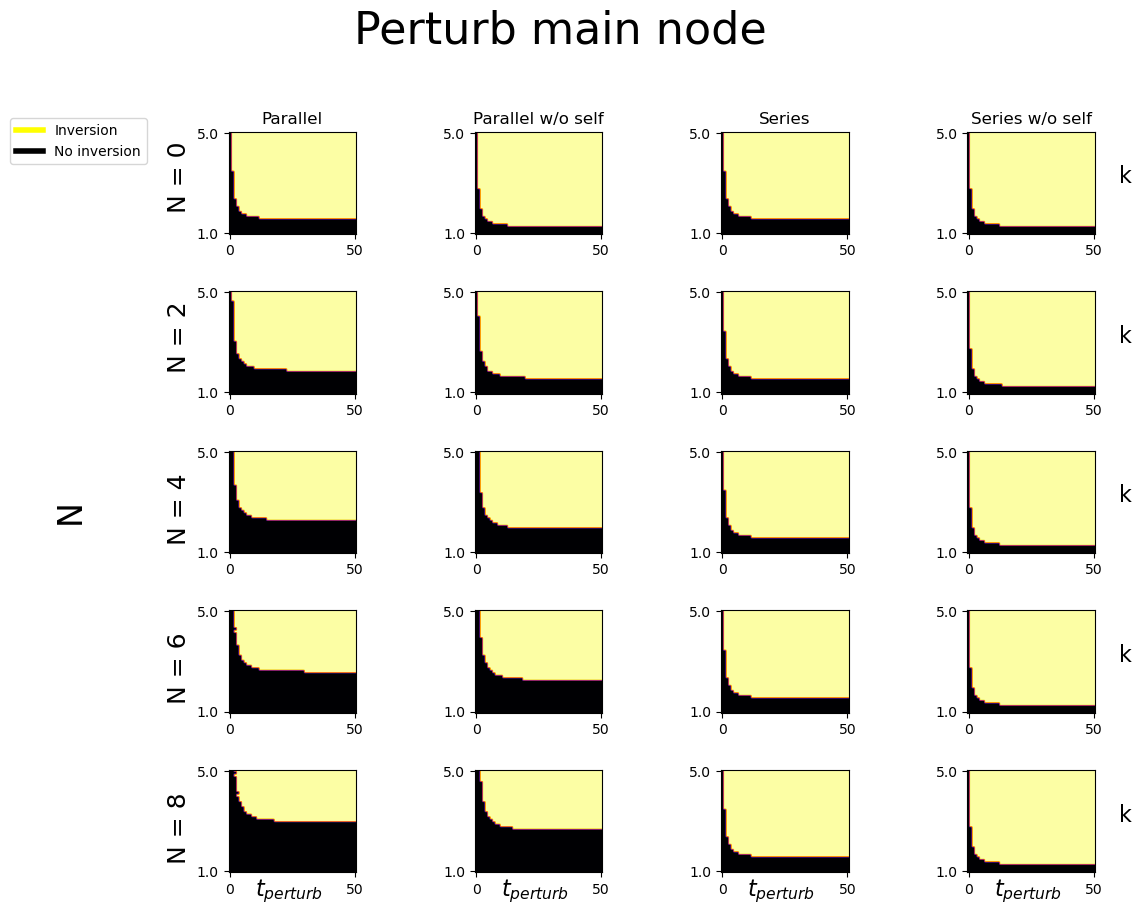

In [28]:
draw_heatmaps(
    [parallel_main_mat_N_k_t, noself_parallel_main_mat_N_k_t, 
        series_main_mat_N_k_t, noself_series_main_mat_N_k_t],
    "Perturb main node",
    "./Results/4_Theoretical_network/main.png")

## Change k, t_perturb and N: secondary node <a class="anchor" id="sec"></a>

### Parallel

#### Self loop.

In [21]:
parallel_sec_sol_n_k_tperturb_t, parallel_sec_sol_n_k_tperturb = get_sols(
    
    get_mswitch_parallel, 
    ode_toggle_parallel, ode_toggle_parallel_perturb, "w",
    N_vec,k_vec,t_perturb_vec,Int(3),
    true
    
);

nn: 0/8	nn: 2/8	nn: 4/8	nn: 6/8	nn: 8/8	

#### No self loop.

In [22]:
noself_parallel_sec_sol_n_k_tperturb_t, noself_parallel_sec_sol_n_k_tperturb = get_sols(
    
    get_mswitch_parallel, 
    ode_toggle_parallel, ode_toggle_parallel_perturb, "wo",
    N_vec,k_vec,t_perturb_vec,Int(3),
    true
    
);

nn: 0/8	nn: 2/8	nn: 4/8	nn: 6/8	nn: 8/8	

### Series

#### Self loop.

In [23]:
series_sec_sol_n_k_tperturb_t, series_sec_sol_n_k_tperturb = get_sols(
    
    get_mswitch_series, 
    ode_toggle_series, ode_toggle_series_perturb, "w",
    N_vec,k_vec,t_perturb_vec,Int(3),
    false
    
);

nn: 0/8	nn: 2/8	nn: 4/8	nn: 6/8	nn: 8/8	

#### No self loop.

In [24]:
noself_series_sec_sol_n_k_tperturb_t, noself_series_sec_sol_n_k_tperturb = get_sols(
    
    get_mswitch_series, 
    ode_toggle_series, ode_toggle_series_perturb, "wo",
    N_vec,k_vec,t_perturb_vec,Int(3),
    false
    
);

nn: 0/8	nn: 2/8	nn: 4/8	nn: 6/8	nn: 8/8	

## Heatmap: secondary <a class="anchor" id="heatmapsec"></a>

We show the results of our simulations:

In [25]:
parallel_sec_mat_N_k_t = get_mat_for_plot(parallel_sec_sol_n_k_tperturb)
noself_parallel_sec_mat_N_k_t = get_mat_for_plot(noself_parallel_sec_sol_n_k_tperturb)
series_sec_mat_N_k_t = get_mat_for_plot(series_sec_sol_n_k_tperturb)
noself_series_sec_mat_N_k_t = get_mat_for_plot(noself_series_sec_sol_n_k_tperturb);

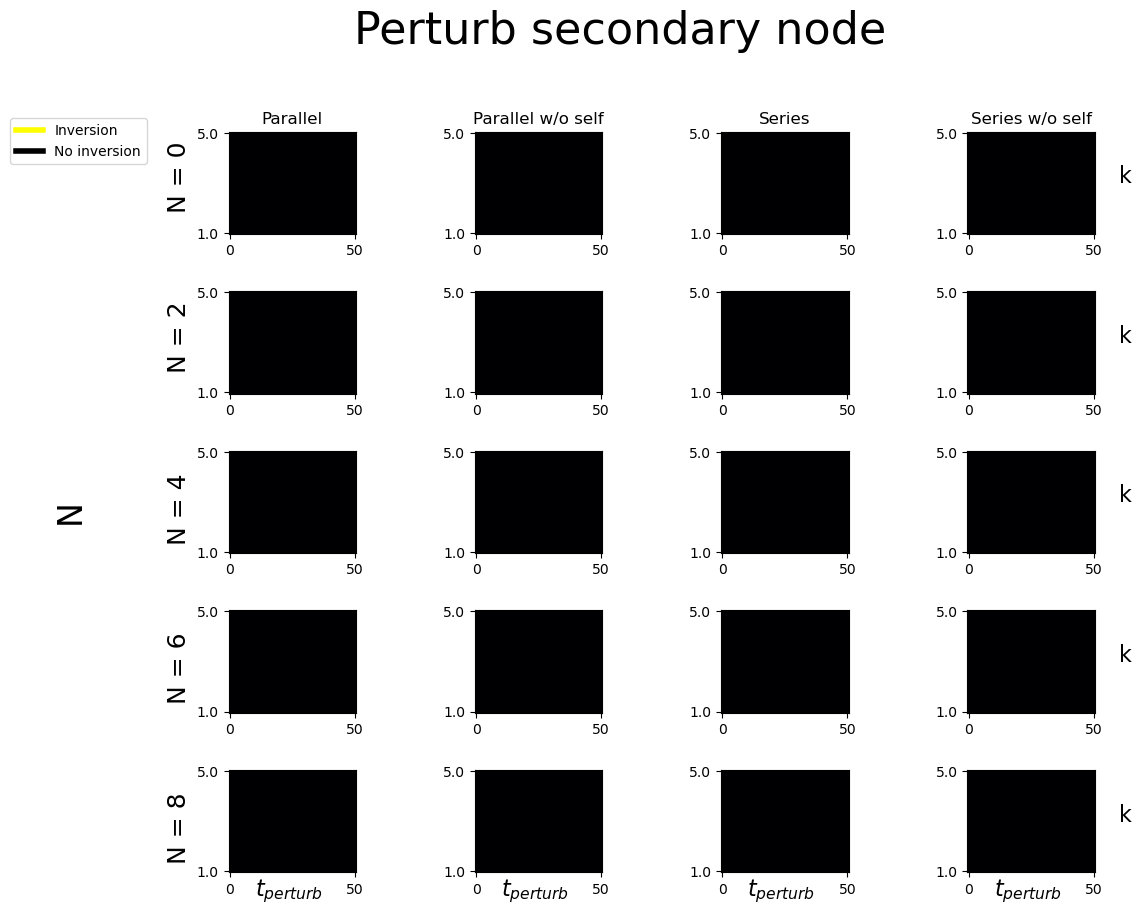

In [27]:
draw_heatmaps(
    [parallel_sec_mat_N_k_t, noself_parallel_sec_mat_N_k_t, 
        series_sec_mat_N_k_t, noself_series_sec_mat_N_k_t],
    "Perturb secondary node",
    "./Results/4_Theoretical_network/secondary.png")